# Implementación de SHAP Y LIME para COMPAS dataset
COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) es un algoritmo comercial popular utilizado por jueces y agentes de libertad condicional para evaluar la probabilidad de reincidencia de los acusados. Se ha demostrado que el algoritmo está sesgado a favor de los acusados ​​blancos y en contra de los reclusos negros, según un estudio de seguimiento de dos años (es decir, quienes cometieron delitos o delitos violentos después de dos años). El patrón de errores, medido por precisión/sensibilidad, es notable.

Los datos contienen variables utilizadas por el algoritmo COMPAS para evaluar a los acusados, junto con sus resultados en los dos años siguientes , los cuáles fueron acusados ​​de delitos penales en el condado de Broward, Florida.

In [1]:
# ==========================================
# 1. IMPORTACIONES
# ==========================================
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import pandas as pd
import numpy as np


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from lime.submodular_pick import SubmodularPick
import shap


## Preprocesamiento 

 Adaptación original de ProPublica  (`propublica compas-analysis – Compas Analysis.ipynb`).

## Pasos de filtrado:
 1. Seleccionar columnas relevantes: `age`, `c_charge_degree`, `race`, `age_cat`,
    `score_text`, `sex`, `priors_count`, `days_b_screening_arrest`, `decile_score`,
    `is_recid`, `two_year_recid`, `c_jail_in`, `c_jail_out`.
 2. Filtrar `days_b_screening_arrest` entre -30 y 30 (calidad del dato).
 3. Eliminar filas donde `is_recid == -1` (no se encontró caso COMPAS).
 4. Eliminar cargos de tránsito ordinario (`c_charge_degree == 'O'`).
 5. Eliminar filas con `score_text == 'N/A'`.


 Referencia: https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm


In [2]:
# ==========================================
# PREPROCESAMIENTO PROPUBLICA (Python puro)
# ==========================================
# Fuente: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
# Traducción fiel del código R/dplyr a pandas.

# --- Paso 0: Lectura del CSV crudo ---
# (ya tenemos 'df' cargado más arriba; lo re-leemos por limpieza)
raw_data = pd.read_csv("data/compas-scores-two-years.csv")
print(f"Filas en el dataset crudo: {len(raw_data)}")

# --- Paso 1: Selección de columnas relevantes ---
# Mismas columnas que el análisis original de ProPublica
cols_to_keep = [
    'age',                    # Edad del acusado
    'c_charge_degree',        # Severidad del cargo (F = Felony, M = Misdemeanor)
    'race',                   # Raza
    'age_cat',                # Categoría de edad (< 25, 25-45, > 45)
    'score_text',             # Clasificación COMPAS: Low / Medium / High
    'sex',                    # Sexo
    'priors_count',           # Número de antecedentes penales
    'days_b_screening_arrest',# Días entre la evaluación COMPAS y el arresto
    'decile_score',           # Puntuación decil COMPAS (1-10)
    'is_recid',               # Flag de reincidencia (-1 si no se encontró caso)
    'two_year_recid',         # ¿Reincidió en dos años? (variable objetivo)
    'c_jail_in',              # Fecha de ingreso a la cárcel
    'c_jail_out',             # Fecha de salida de la cárcel
]
df_filtered = raw_data[cols_to_keep].copy()

# --- Paso 2: Filtro por calidad del dato ---
# Si la fecha del cargo puntuado por COMPAS no está dentro de 30 días del arresto,
# asumimos que no tenemos el delito correcto (calidad de datos).
df_filtered = df_filtered[
    (df_filtered['days_b_screening_arrest'] <= 30) &
    (df_filtered['days_b_screening_arrest'] >= -30)
]

# --- Paso 3: Eliminar filas sin caso COMPAS ---
# is_recid == -1 indica que no se pudo encontrar un caso COMPAS
df_filtered = df_filtered[df_filtered['is_recid'] != -1]

# --- Paso 4: Eliminar infracciones de tránsito ordinarias ---
# c_charge_degree == 'O' son infracciones de tránsito que no resultan en cárcel
df_filtered = df_filtered[df_filtered['c_charge_degree'] != 'O']

# --- Paso 5: Eliminar puntuaciones N/A ---
df_filtered = df_filtered[df_filtered['score_text'] != 'N/A']

print(f"Filas después del filtrado ProPublica: {len(df_filtered)}")

# --- Paso 6: Calcular duración de estancia (length_of_stay) ---
# Correlación mencionada en el análisis original
df_filtered['c_jail_in']  = pd.to_datetime(df_filtered['c_jail_in'])
df_filtered['c_jail_out'] = pd.to_datetime(df_filtered['c_jail_out'])
df_filtered['length_of_stay'] = (df_filtered['c_jail_out'] - df_filtered['c_jail_in']).dt.days

corr_stay_score = df_filtered['length_of_stay'].corr(df_filtered['decile_score'])
print(f"Correlación entre duración de estancia y decile_score: {corr_stay_score:.4f}")
# Esperado: ~0.207


Filas en el dataset crudo: 7214
Filas después del filtrado ProPublica: 6172
Correlación entre duración de estancia y decile_score: 0.2075


In [3]:
# ==========================================
# PALETA DE COLORES GLOBAL (consistente en todo el notebook)
# ==========================================
total = len(df_filtered)

# Paleta principal — tonos cálidos/fríos que combinan entre sí
RACE_COLORS = {
    'African-American': '#5B8DB8',   # azul acero
    'Caucasian':        '#F2A154',   # naranja suave
    'Hispanic':         '#7FBC8C',   # verde salvia
    'Asian':            '#C97B84',   # rosa empolvado
    'Native American':  '#9B8EC1',   # lavanda
    'Other':            '#B5A886',   # arena
}
AGE_COLORS  = ['#7FBC8C', '#5B8DB8', '#F2A154']     # verde, azul, naranja
SEX_COLORS  = ['#5B8DB8', '#C97B84']                 # azul, rosa
RISK_COLORS = ['#7FBC8C', '#F2A154', '#D96459']      # verde, naranja, rojo suave
RECID_COLORS = ['#D96459', '#7FBC8C']                # rojo suave, verde

print(f"Registros post-filtrado ProPublica: {total:,}")

Registros post-filtrado ProPublica: 6,172


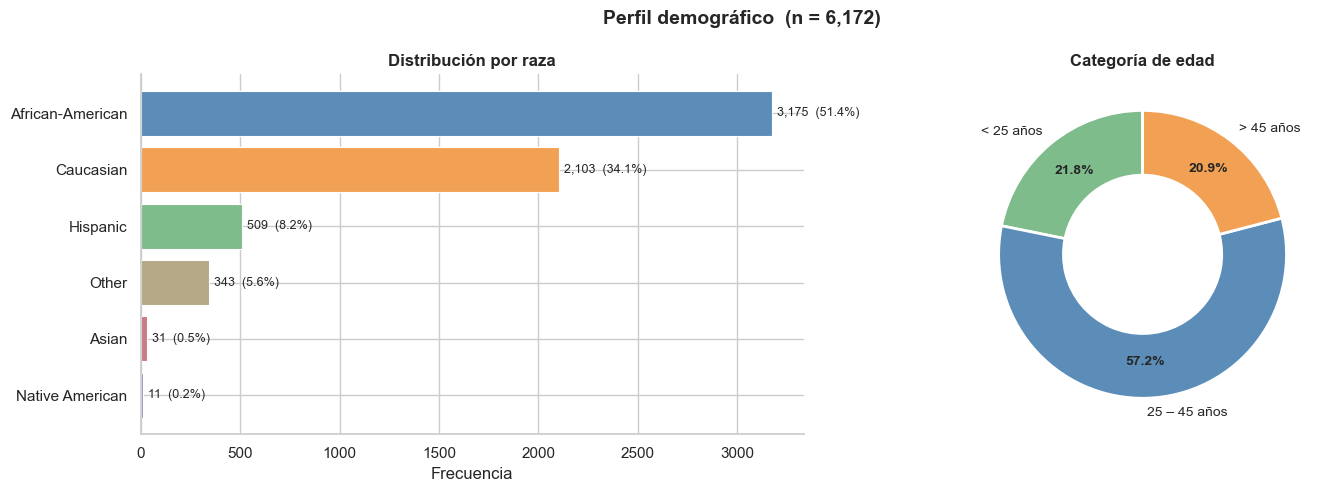

In [4]:
# ==========================================
# 1/3  RAZA  &  CATEGORÍA DE EDAD
# ==========================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'Perfil demográfico  (n = {total:,})', fontsize=14, fontweight='bold')

# ── Distribución por raza (barras horizontales) ──
race_counts = df_filtered['race'].value_counts()
colors_race = [RACE_COLORS.get(r, '#BBBBBB') for r in race_counts.index]
bars = ax1.barh(race_counts.index, race_counts.values, color=colors_race,
                edgecolor='white', linewidth=0.8)
ax1.set_title('Distribución por raza', fontweight='bold', fontsize=12)
ax1.set_xlabel('Frecuencia')
ax1.invert_yaxis()
for bar, val in zip(bars, race_counts.values):
    pct = val / total * 100
    ax1.text(bar.get_width() + 25, bar.get_y() + bar.get_height()/2,
             f'{val:,}  ({pct:.1f}%)', va='center', fontsize=9)
ax1.spines[['top', 'right']].set_visible(False)

# ── Categoría de edad (donut) ──
age_order = ['Less than 25', '25 - 45', 'Greater than 45']
age_labels = ['< 25 años', '25 – 45 años', '> 45 años']
age_counts = df_filtered['age_cat'].value_counts().reindex(age_order)
wedges, texts, autotexts = ax2.pie(
    age_counts.values, labels=age_labels, autopct='%1.1f%%',
    colors=AGE_COLORS, startangle=90, pctdistance=0.75,
    wedgeprops=dict(width=0.45, edgecolor='white', linewidth=2),
    textprops={'fontsize': 10}
)
for t in autotexts:
    t.set_fontweight('bold')
ax2.set_title('Categoría de edad', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

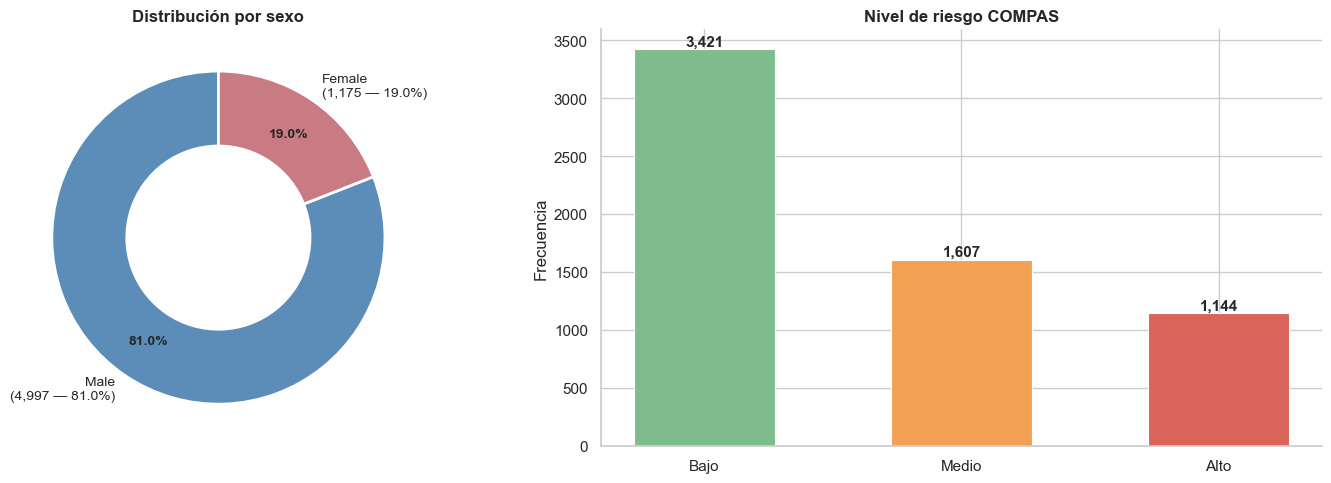

In [5]:
# ==========================================
# 2/3  SEXO  &  NIVEL DE RIESGO COMPAS
# ==========================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ── Distribución por sexo (donut) ──
sex_counts = df_filtered['sex'].value_counts()
sex_labels = [f'{s}\n({v:,} — {v/total*100:.1f}%)' for s, v in sex_counts.items()]
wedges, texts, autotexts = ax1.pie(
    sex_counts.values, labels=sex_labels, autopct='%1.1f%%',
    colors=SEX_COLORS, startangle=90, pctdistance=0.75,
    wedgeprops=dict(width=0.45, edgecolor='white', linewidth=2),
    textprops={'fontsize': 10}
)
for t in autotexts:
    t.set_fontweight('bold')
ax1.set_title('Distribución por sexo', fontweight='bold', fontsize=12)

# ── Nivel de riesgo COMPAS (barras) ──
score_order = ['Low', 'Medium', 'High']
score_labels_es = ['Bajo', 'Medio', 'Alto']
score_counts = df_filtered['score_text'].value_counts().reindex(score_order)
bars = ax2.bar(score_labels_es, score_counts.values, color=RISK_COLORS,
               edgecolor='white', linewidth=0.8, width=0.55)
ax2.set_title('Nivel de riesgo COMPAS', fontweight='bold', fontsize=12)
ax2.set_ylabel('Frecuencia')
for bar, val in zip(bars, score_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
             f'{val:,}', ha='center', fontsize=11, fontweight='bold')
ax2.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

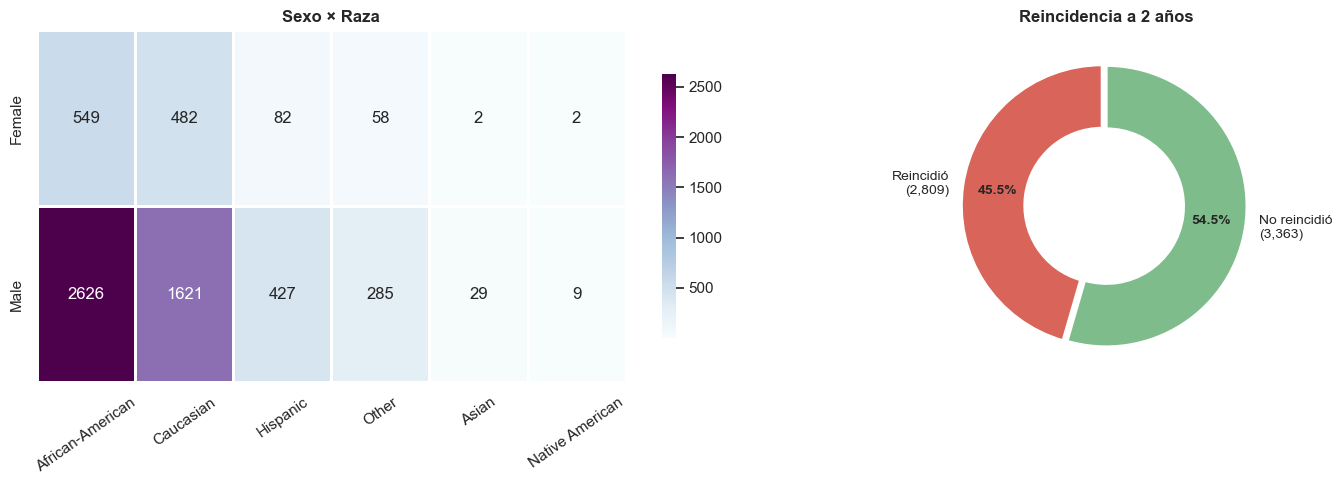


───────────────────────────────────────────────────────
  Total registros:   6,172
  Reincidencia:      45.5%
  Hombres / Mujeres: 81.0% / 19.0%
───────────────────────────────────────────────────────


In [6]:
# ==========================================
# 3/3  SEXO × RAZA (heatmap)  &  REINCIDENCIA A 2 AÑOS
# ==========================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ── Heatmap sexo × raza ──
ct = pd.crosstab(df_filtered['sex'], df_filtered['race'])
# Reordenar columnas por tamaño descendente para mejor lectura
ct = ct[race_counts.index]
sns.heatmap(ct, annot=True, fmt='d', cmap='BuPu', ax=ax1,
            linewidths=1, linecolor='white', cbar_kws={'shrink': 0.75})
ax1.set_title('Sexo × Raza', fontweight='bold', fontsize=12)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.tick_params(axis='x', rotation=35)

# ── Reincidencia a 2 años (donut) ──
recid_count = int(df_filtered['two_year_recid'].sum())
no_recid = total - recid_count
recid_labels = [f'Reincidió\n({recid_count:,})', f'No reincidió\n({no_recid:,})']
wedges, texts, autotexts = ax2.pie(
    [recid_count, no_recid], labels=recid_labels, autopct='%1.1f%%',
    colors=RECID_COLORS, startangle=90, pctdistance=0.75,
    wedgeprops=dict(width=0.45, edgecolor='white', linewidth=2),
    textprops={'fontsize': 10}, explode=(0.03, 0)
)
for t in autotexts:
    t.set_fontweight('bold')
ax2.set_title('Reincidencia a 2 años', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

# ── Resumen compacto ──
print("\n" + "─"*55)
print(f"  Total registros:   {total:,}")
print(f"  Reincidencia:      {recid_count/total*100:.1f}%")
print(f"  Hombres / Mujeres: {sex_counts.get('Male',0)/total*100:.1f}% / {sex_counts.get('Female',0)/total*100:.1f}%")
print("─"*55)

In [9]:
# Creamos las variables derivadas 
df_model = df_filtered.copy()

# score_factor: True si score_text != "Low" → 1 (HighScore), 0 (LowScore)
df_model['score_factor'] = (df_model['score_text'] != 'Low').astype(int)

# crime_factor: severidad del cargo (F / M)
df_model['crime_factor'] = df_model['c_charge_degree']

# age_factor: categoría de edad (referencia = "25 - 45")
df_model['age_factor'] = pd.Categorical(
    df_model['age_cat'],
    categories=['25 - 45', 'Greater than 45', 'Less than 25']
)

# race_factor: raza (referencia = "Caucasian")
df_model['race_factor'] = pd.Categorical(
    df_model['race'],
    categories=['Caucasian', 'African-American', 'Asian', 'Hispanic', 'Native American', 'Other']
)

# gender_factor: sexo (referencia = "Male")
df_model['gender_factor'] = pd.Categorical(
    df_model['sex'],
    categories=['Male', 'Female']
)


# Entrenamiento - RandomForest

In [10]:
# ==========================================
# PREPARACIÓN FINAL: X, y, cols PARA MODELADO
# ==========================================
# El objetivo es entrenar un modelo que prediga reincidencia usando SOLO
# las variables observables (demográficas + historial criminal), y luego
# comparar su comportamiento con COMPAS usando SHAP/LIME.

df_prep = df_filtered.copy()

# Variable objetivo
y = df_prep['two_year_recid'].astype(int)

# Features numéricas (sin decile_score)
feature_cols = [
    'age',              # Edad del acusado
    'priors_count',     # Número de antecedentes penales
    'length_of_stay',   # Días en custodia
]

# Features categóricas
cat_features_drop = ['sex', 'c_charge_degree']   # drop_first OK aquí
cat_features_keep = ['race']                       # queremos TODAS las razas (incl. African-American)

X = df_prep[feature_cols + cat_features_drop + cat_features_keep].copy()

# Dummies: drop_first solo para sex y c_charge_degree
X = pd.get_dummies(X, columns=cat_features_drop, drop_first=True)
X = pd.get_dummies(X, columns=cat_features_keep, drop_first=False)

# Rellenamos NaN residuales (length_of_stay puede tener algunos)
X = X.fillna(0)
#Vamos a introducir una variable aleatoria para ver su importancia en el modelo
np.random.seed(42)
X['random_noise'] = np.random.rand(len(X))

cols = X.columns.tolist()

print(f"Shape de X: {X.shape}")
print(f"Distribución de y:\n{y.value_counts()}")
print(f"\nColumnas finales ({len(cols)}):")
for i, c in enumerate(cols):
    print(f"  {i+1:2d}. {c}")

Shape de X: (6172, 12)
Distribución de y:
two_year_recid
0    3363
1    2809
Name: count, dtype: int64

Columnas finales (12):
   1. age
   2. priors_count
   3. length_of_stay
   4. sex_Male
   5. c_charge_degree_M
   6. race_African-American
   7. race_Asian
   8. race_Caucasian
   9. race_Hispanic
  10. race_Native American
  11. race_Other
  12. random_noise


Entrenamiento: 4,937 | Prueba: 1,235
Tasa de reincidencia — Train: 0.455 | Test: 0.455

  Accuracy: 69.47%

Classification Report:
              precision    recall  f1-score   support

No reincidió       0.69      0.79      0.74       673
   Reincidió       0.70      0.58      0.63       562

    accuracy                           0.69      1235
   macro avg       0.70      0.69      0.69      1235
weighted avg       0.70      0.69      0.69      1235



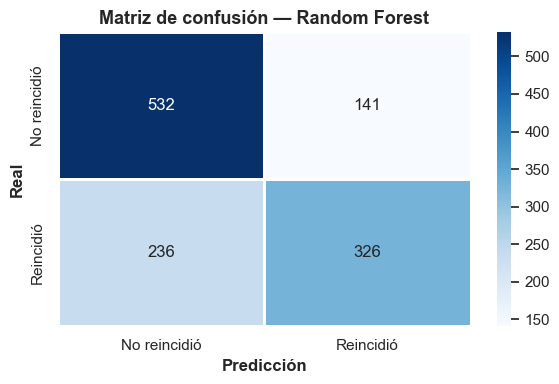

In [11]:
# ==========================================
# ENTRENAMIENTO RANDOM FOREST
# ==========================================

# División 80/20 estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Entrenamiento: {X_train.shape[0]:,} | Prueba: {X_test.shape[0]:,}")
print(f"Tasa de reincidencia — Train: {y_train.mean():.3f} | Test: {y_test.mean():.3f}")

# Modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

# Métricas
print(f"\n{'='*50}")
print(f"  Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(f"{'='*50}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No reincidió', 'Reincidió']))

# Matriz de confusión visual
fig, ax = plt.subplots(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['No reincidió', 'Reincidió'],
            yticklabels=['No reincidió', 'Reincidió'],
            linewidths=1, linecolor='white')
ax.set_xlabel('Predicción', fontweight='bold')
ax.set_ylabel('Real', fontweight='bold')
ax.set_title('Matriz de confusión — Random Forest', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

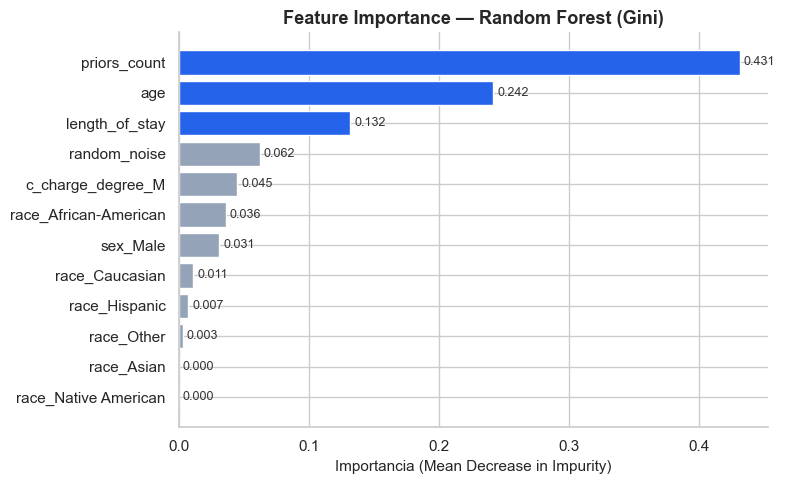


 Ranking de importancia (Gini / MDI):

   1. priors_count               0.4312  ██████████████████████████████████
   2. age                        0.2416  ███████████████████
   3. length_of_stay             0.1318  ██████████
   4. random_noise               0.0621  ████
   5. c_charge_degree_M          0.0448  ███
   6. race_African-American      0.0362  ██
   7. sex_Male                   0.0309  ██
   8. race_Caucasian             0.0110  
   9. race_Hispanic              0.0073  
  10. race_Other                 0.0029  
  11. race_Asian                 0.0001  
  12. race_Native American       0.0000  


In [12]:
# ==========================================
# FEATURE IMPORTANCE — Random Forest (Gini / MDI)
# ==========================================
# Importancia basada en la reducción media de impureza (Mean Decrease in Impurity).
# Es la métrica nativa del Random Forest: cuánto reduce cada feature la impureza
# Gini promediada sobre todos los árboles del ensemble.



fi = pd.Series(rf_model.feature_importances_, index=cols).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(8, 5))
top3_color = '#2563EB'
other_color = '#94A3B8'
colors = [top3_color if i >= len(fi) - 3 else other_color for i in range(len(fi))]
bars = ax.barh(fi.index, fi.values, color=colors)

# Etiquetas con el valor
for bar, val in zip(bars, fi.values):
    ax.text(bar.get_width() + 0.003, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=9, color='#333333')

ax.set_xlabel('Importancia (Mean Decrease in Impurity)', fontsize=11)
ax.set_title('Feature Importance — Random Forest (Gini)', fontweight='bold', fontsize=13)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

# Ranking en texto
print("\n Ranking de importancia (Gini / MDI):\n")
for rank, (feat, val) in enumerate(fi.sort_values(ascending=False).items(), 1):
    bar = '█' * int(val * 80)
    print(f"  {rank:2d}. {feat:<25s}  {val:.4f}  {bar}")

## LIME — Local Interpretable Model-agnostic Explanations

LIME genera explicaciones locales para predicciones individuales. Funciona perturbando la entrada y ajustando un modelo simple (regresión lineal) alrededor de la predicción para entender qué features la impulsan.

LIME es model-agnostic: funciona con cualquier modelo de caja negra.

 LIME — Explicación para el acusado #0 del test set
   Predicción: Reincidió
   Real:       Reincidió



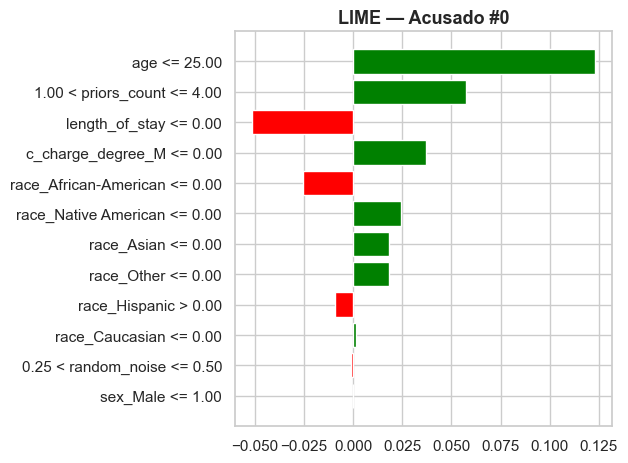


 LIME — Explicación para el acusado #10 del test set
   Predicción: No reincidió
   Real:       Reincidió



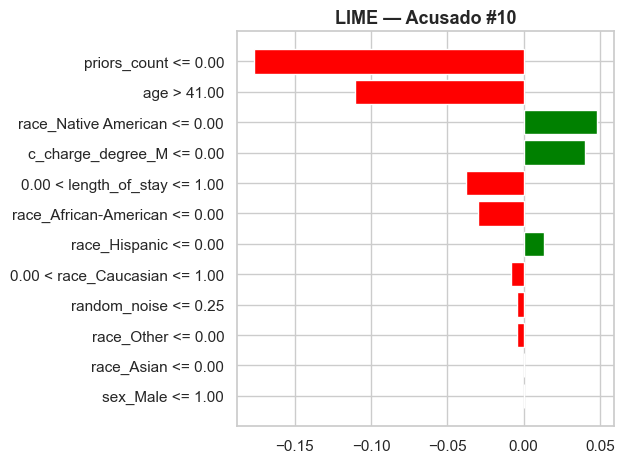

In [13]:
# ==========================================
# LIME — Explicabilidad local
# ==========================================
import lime
import lime.lime_tabular

# Crear el explicador LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=cols,
    class_names=['No reincidió', 'Reincidió'],
    mode='classification',
    random_state=42
)

# --- Explicación del acusado #0 (mismo que SHAP para comparar) ---
print(" LIME — Explicación para el acusado #0 del test set")
print(f"   Predicción: {'Reincidió' if y_pred[0] == 1 else 'No reincidió'}")
print(f"   Real:       {'Reincidió' if y_test.iloc[0] == 1 else 'No reincidió'}\n")

exp_0 = lime_explainer.explain_instance(
    X_test.iloc[0].values,
    rf_model.predict_proba,
    num_features=len(cols)
)
exp_0.as_pyplot_figure()
plt.title('LIME — Acusado #0', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

# --- Explicación de un segundo acusado (índice 10) para contraste ---
print("\n LIME — Explicación para el acusado #10 del test set")
print(f"   Predicción: {'Reincidió' if y_pred[10] == 1 else 'No reincidió'}")
print(f"   Real:       {'Reincidió' if y_test.iloc[10] == 1 else 'No reincidió'}\n")

exp_10 = lime_explainer.explain_instance(
    X_test.iloc[10].values,
    rf_model.predict_proba,
    num_features=len(cols)
)
exp_10.as_pyplot_figure()
plt.title('LIME — Acusado #10', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

## SP-LIME — Submodular Pick LIME

LIME explica instancias individuales, pero **¿cómo obtener una visión global del modelo con explicaciones locales?**

**SP-LIME** (Ribeiro et al., 2016) resuelve esto seleccionando un subconjunto representativo de explicaciones que maximiza la **cobertura de features** usando optimización submodular greedy:

1. Genera explicaciones LIME para muchas instancias.
2. Construye una **matriz de importancia** $W_{ij}$ = peso absoluto de la feature $j$ en la explicación de la instancia $i$.
3. Selecciona iterativamente las instancias cuyas explicaciones cubren la mayor diversidad de features (maximización de cobertura submodular).

El resultado es un conjunto pequeño de explicaciones que, vistas juntas, dan una **comprensión global** del comportamiento del modelo — similar a SHAP global, pero construida desde explicaciones locales.

In [14]:
# ==========================================
# SP-LIME — Submodular Pick
# ==========================================


# --- 1. Ejecutar SP-LIME ---
print(" Ejecutando SP-LIME...")
sp = SubmodularPick(
    lime_explainer,
    data=X_test.values,
    predict_fn=rf_model.predict_proba,
    sample_size=500,
    num_features=len(cols),
    num_exps_desired=6,
)

print(f" SP-LIME seleccionó {len(sp.sp_explanations)} explicaciones representativas")
print(f"   Total de explicaciones candidatas: {len(sp.explanations)}\n")


 Ejecutando SP-LIME...
 SP-LIME seleccionó 6 explicaciones representativas
   Total de explicaciones candidatas: 500



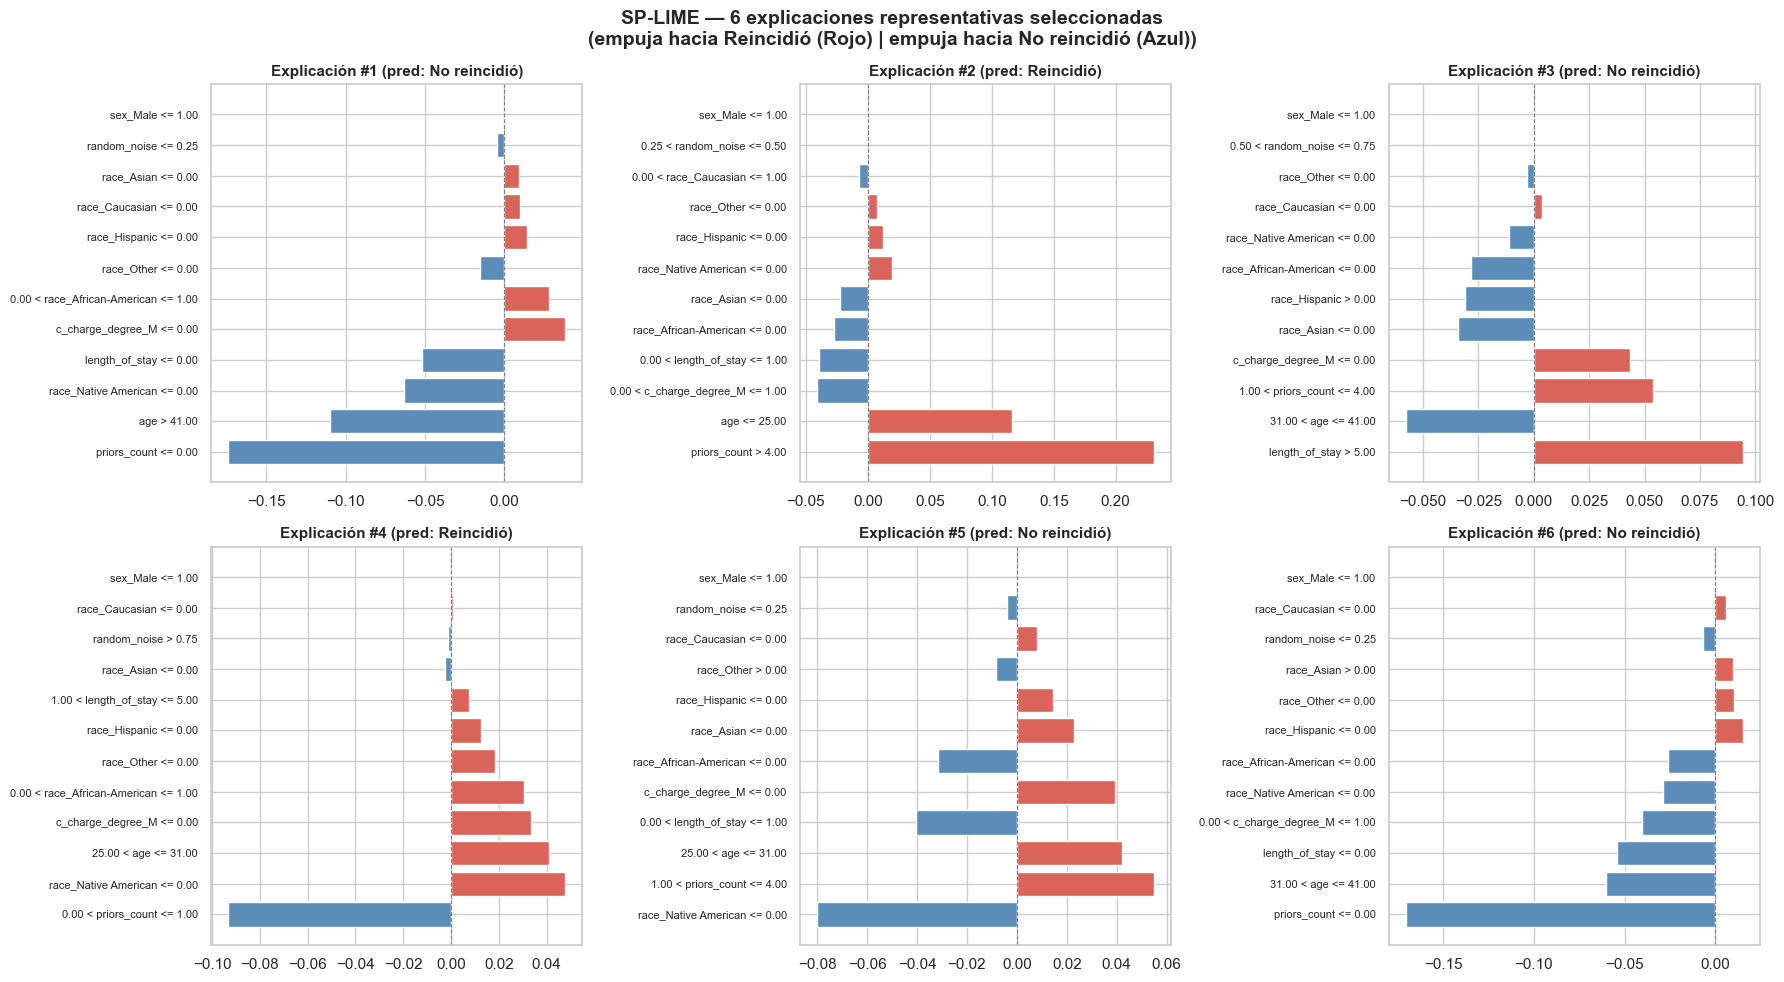

In [15]:

# --- 2. Mostrar las 6 explicaciones representativas ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, exp in enumerate(sp.sp_explanations):
    ax = axes[i]
    available_label = exp.available_labels()[0]
    feat_weights = exp.as_list(label=available_label)
    feat_names = [fw[0] for fw in feat_weights]
    weights = [fw[1] for fw in feat_weights]

    if available_label == 0:
        weights = [-w for w in weights]

    colors = ['#D96459' if w > 0 else '#5B8DB8' for w in weights]
    ax.barh(feat_names, weights, color=colors)
    pred_label = 'Reincidió' if available_label == 1 else 'No reincidió'
    ax.set_title(f'Explicación #{i+1} (pred: {pred_label})',
                 fontweight='bold', fontsize=11)
    ax.axvline(x=0, color='gray', linewidth=0.8, linestyle='--')
    ax.tick_params(axis='y', labelsize=8)

fig.suptitle('SP-LIME — 6 explicaciones representativas seleccionadas\n'
             '(empuja hacia Reincidió (Rojo) | empuja hacia No reincidió (Azul))',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

 Importancia global (SP-LIME) — promedio |peso| sobre las 500 explicaciones:

   1. priors_count               0.1386  ████████████████████
   2. age                        0.0847  ████████████
   3. length_of_stay             0.0528  ███████
   4. c_charge_degree_M          0.0391  █████
   5. race_African-American      0.0288  ████
   6. race_Native American       0.0268  ████
   7. race_Asian                 0.0189  ██
   8. race_Hispanic              0.0183  ██
   9. race_Other                 0.0073  █
  10. race_Caucasian             0.0060  
  11. random_noise               0.0034  
  12. sex_Male                   0.0000  


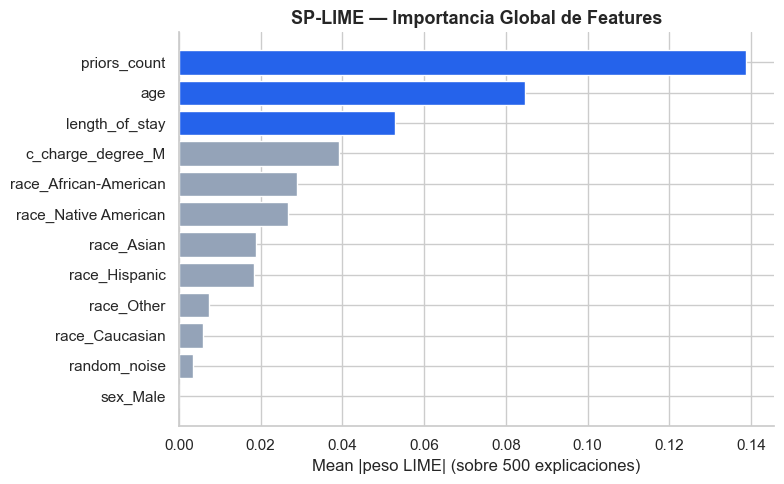

In [16]:


# --- 3. Importancia global pseudo-agregada desde SP-LIME ---
# LIME discretiza los nombres (ej. "priors_count > 4.00").
# Mapeamos cada nombre discretizado al feature original.
def lime_name_to_feature(lime_name, feature_list):
    """Mapea 'priors_count > 4.00' → 'priors_count', etc."""
    for feat in sorted(feature_list, key=len, reverse=True):
        if feat in lime_name:
            return feat
    return lime_name  # fallback

# Agregar pesos absolutos por feature original
feat_abs_weights = {f: [] for f in cols}

for e in sp.explanations:
    lbl = e.available_labels()[0]
    local_dict = {}
    for lime_name, weight in e.as_list(label=lbl):
        original_feat = lime_name_to_feature(lime_name, cols)
        local_dict[original_feat] = local_dict.get(original_feat, 0) + abs(weight)
    for f in cols:
        feat_abs_weights[f].append(local_dict.get(f, 0.0))

sp_importance = pd.Series({f: np.mean(feat_abs_weights[f]) for f in cols})
sp_importance = sp_importance.sort_values(ascending=False)

print(" Importancia global (SP-LIME) — promedio |peso| sobre las 500 explicaciones:\n")
for rank, (feat, val) in enumerate(sp_importance.items(), 1):
    bar = '█' * int(val * 150)
    print(f"  {rank:2d}. {feat:<25s}  {val:.4f}  {bar}")

# --- 4. Gráfico de importancia global SP-LIME ---
fig, ax = plt.subplots(figsize=(8, 5))
sp_plot = sp_importance.sort_values(ascending=True)
top3_color = '#2563EB'
other_color = '#94A3B8'
colors = [top3_color if i >= len(sp_plot) - 3 else other_color
          for i in range(len(sp_plot))]
ax.barh(sp_plot.index, sp_plot.values, color=colors)
ax.set_xlabel('Mean |peso LIME| (sobre 500 explicaciones)')
ax.set_title('SP-LIME — Importancia Global de Features', fontweight='bold', fontsize=13)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

## SHAP — SHapley Additive exPlanations

SHAP asigna a cada feature un **valor de contribución** para cada predicción individual, basándose en la teoría de juegos cooperativos (valores de Shapley).

- **Summary plot (beeswarm)**: muestra la importancia global de cada variable y la dirección de su efecto.
- **Waterfall plot**: descompone una predicción individual mostrando cómo cada feature empuja la predicción desde la base hacia el resultado final.
- **Dependence plot**: muestra cómo varía el efecto SHAP de una variable a lo largo de sus valores.

Summary Plot — ¿Qué variables importan más globalmente?


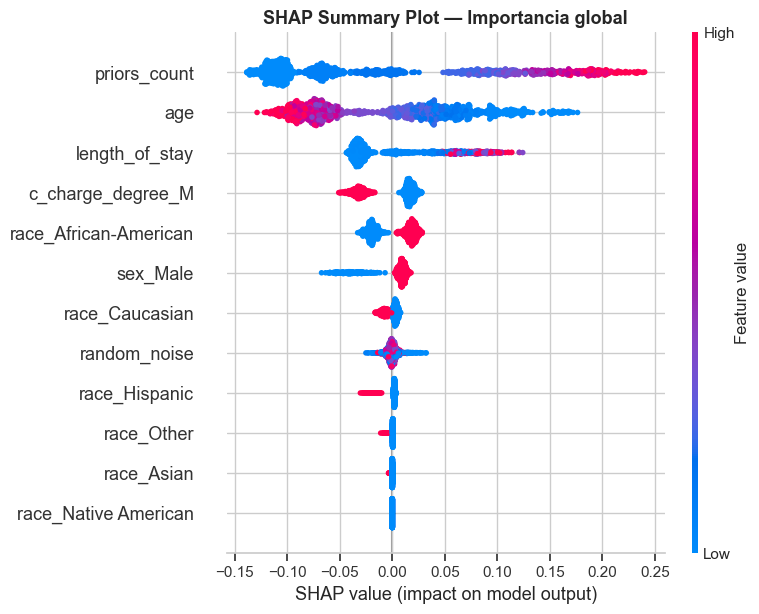

In [17]:
# ==========================================
# SHAP — Explicabilidad global
# ==========================================
import shap

# TreeExplainer: específico y rápido para modelos basados en árboles
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X_test)

# --- 1. Summary Plot (Beeswarm) — Importancia global ---
# Cada punto es una observación. El color indica si el valor de la feature
# es alto (rojo) o bajo (azul). La posición en X indica el impacto SHAP.
print("Summary Plot — ¿Qué variables importan más globalmente?")
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=cols, show=False)
plt.title('SHAP Summary Plot — Importancia global', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

 Waterfall Plot — Explicación para el acusado #0 del test set
   Predicción: Reincidió
   Real:       Reincidió


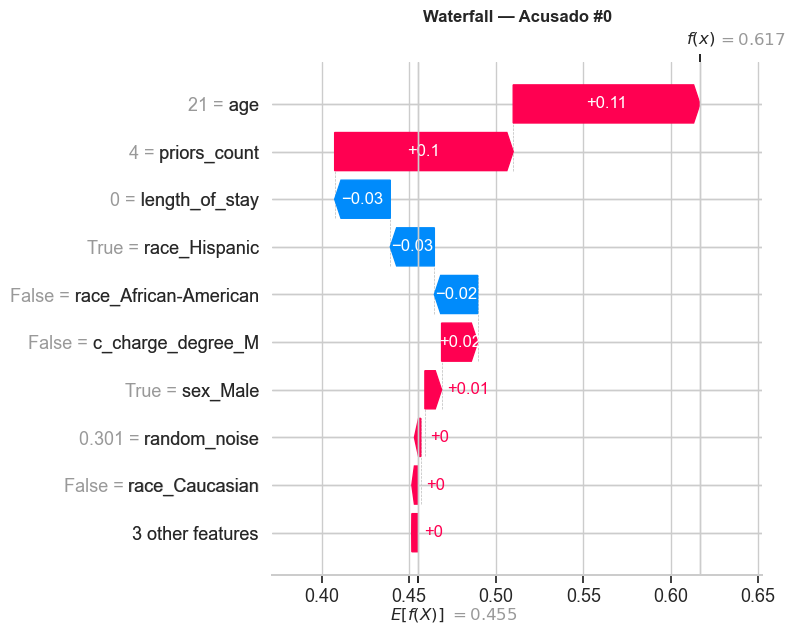

 Waterfall Plot — Explicación para el acusado #10 del test set
   Predicción: No reincidió
   Real:       Reincidió


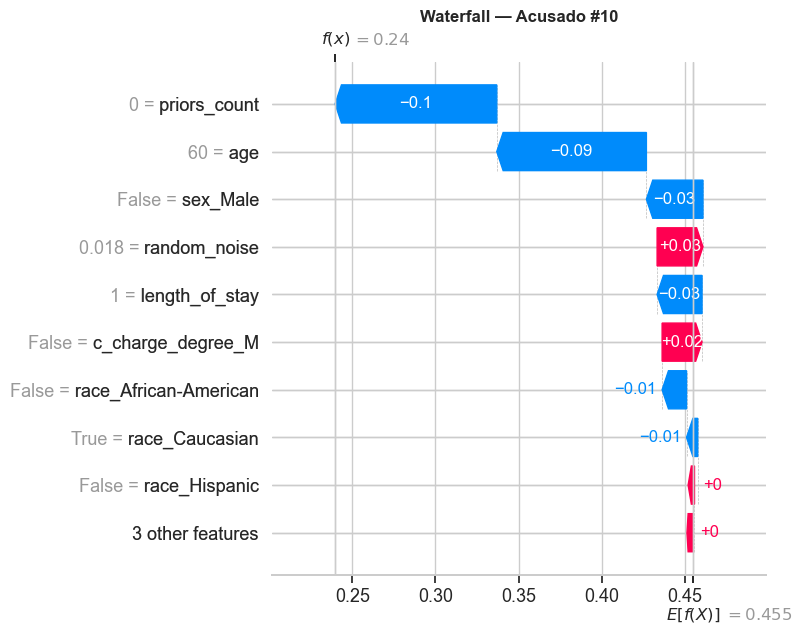

In [18]:
# ==========================================
# SHAP — Waterfall (explicación individual)
# ==========================================
# Para clasificación binaria con RF, shap_values tiene shape (n, features, 2).
# Usamos la clase 1 (reincidió).
shap_vals_class1 = shap_values[:, :, 1]

# Ejemplo: primer acusado del conjunto de prueba
print(" Waterfall Plot — Explicación para el acusado #0 del test set")
print(f"   Predicción: {'Reincidió' if y_pred[0] == 1 else 'No reincidió'}")
print(f"   Real:       {'Reincidió' if y_test.iloc[0] == 1 else 'No reincidió'}")
shap.plots.waterfall(shap_vals_class1[0], show=False)
plt.title('Waterfall — Acusado #0', fontweight='bold')
plt.tight_layout()
plt.show()

# Ejemplo: acusado #10 del conjunto de prueba
print(" Waterfall Plot — Explicación para el acusado #10 del test set")
print(f"   Predicción: {'Reincidió' if y_pred[10] == 1 else 'No reincidió'}")
print(f"   Real:       {'Reincidió' if y_test.iloc[10] == 1 else 'No reincidió'}")
shap.plots.waterfall(shap_vals_class1[10], show=False)
plt.title('Waterfall — Acusado #10', fontweight='bold')
plt.tight_layout()
plt.show()


Force Plot — Acusado #0 del test set
   Predicción: Reincidió
   Real:       Reincidió



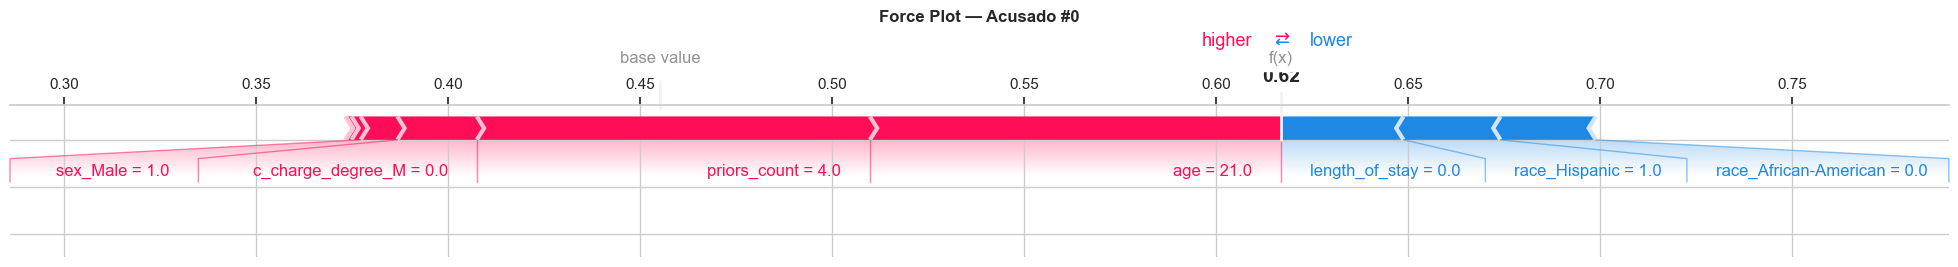

In [19]:
# ==========================================
# SHAP — Force Plot
# ==========================================
import shap

# Inicializar JS para force plots interactivos
shap.initjs()

# --- 1. Force Plot individual: acusado #0 ---
# Muestra cómo cada feature empuja la predicción desde la base (E[f(x)])
# hacia el valor predicho. Rojo = empuja hacia reincidió, azul = hacia no reincidió.
print("Force Plot — Acusado #0 del test set")
print(f"   Predicción: {'Reincidió' if y_pred[0] == 1 else 'No reincidió'}")
print(f"   Real:       {'Reincidió' if y_test.iloc[0] == 1 else 'No reincidió'}\n")

# expected_value para clase 1 (reincidió)
base_value = explainer.expected_value[1]

shap.force_plot(
    base_value,
    shap_vals_class1[0].values,
    X_test.iloc[0],
    feature_names=cols,
    matplotlib=True,
    show=False
)
plt.title('Force Plot — Acusado #0', fontweight='bold', fontsize=12, pad=60)
plt.tight_layout()
plt.show()

Force Plot — Acusado #10 del test set
   Predicción: No reincidió
   Real:       Reincidió



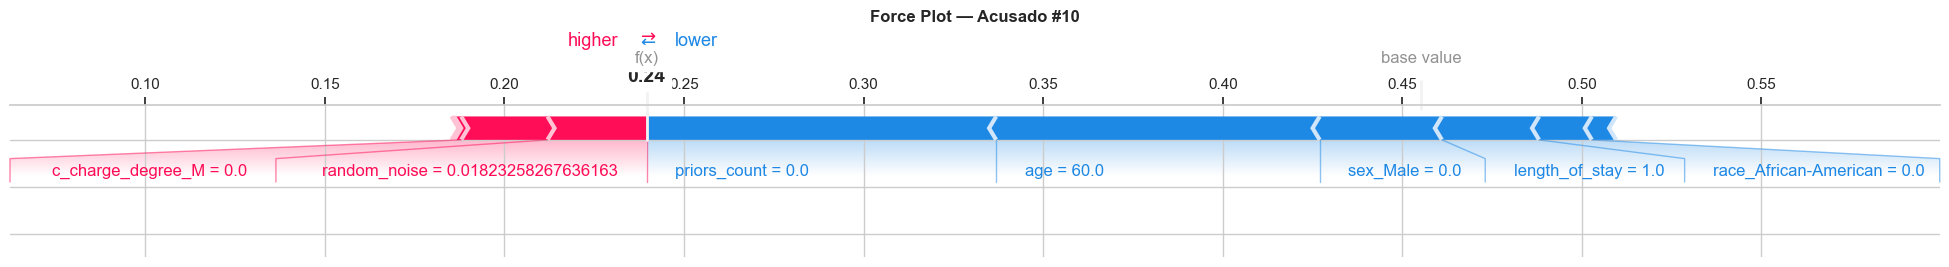

In [20]:
# ==========================================
# SHAP — Force Plot
# ==========================================
import shap

# Inicializar JS para force plots interactivos
shap.initjs()

# --- 1. Force Plot individual: acusado #10 ---
# Muestra cómo cada feature empuja la predicción desde la base (E[f(x)])
# hacia el valor predicho. Rojo = empuja hacia reincidió, azul = hacia no reincidió.
print("Force Plot — Acusado #10 del test set")
print(f"   Predicción: {'Reincidió' if y_pred[10] == 1 else 'No reincidió'}")
print(f"   Real:       {'Reincidió' if y_test.iloc[10] == 1 else 'No reincidió'}\n")

# expected_value para clase 1 (reincidió)
base_value = explainer.expected_value[1]

shap.force_plot(
    base_value,
    shap_vals_class1[10].values,
    X_test.iloc[10],
    feature_names=cols,
    matplotlib=True,
    show=False
)
plt.title('Force Plot — Acusado #10', fontweight='bold', fontsize=12, pad=60)
plt.tight_layout()
plt.show()



In [21]:
# --- 2. Force Plot colectivo: todo el test set ---
# Vista panorámica: cada fila es una instancia, ordenadas por valor de predicción.
# Permite ver patrones globales en las contribuciones.
print("\n Force Plot colectivo — Todo el test set (clase: Reincidió)")
shap.force_plot(
    base_value,
    shap_vals_class1.values,
    X_test,
    feature_names=cols
)


 Force Plot colectivo — Todo el test set (clase: Reincidió)



 Dependence Plot — priors_count (coloreado por race_African-American)


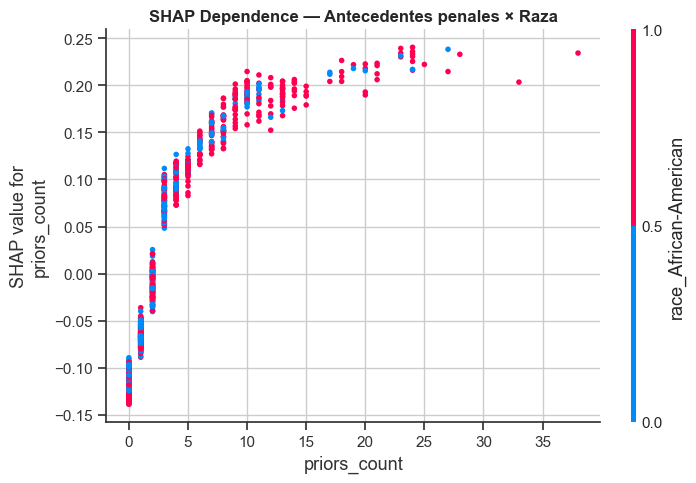

In [22]:
# --- Dependence plot: priors_count coloreado por raza ---
# Muestra cómo cambia el efecto SHAP de los antecedentes penales
# y si ser afroamericano interactúa con esa variable
print("\n Dependence Plot — priors_count (coloreado por race_African-American)")
shap.dependence_plot('priors_count', shap_vals_class1.values, X_test,
                     feature_names=cols,
                     interaction_index='race_African-American',
                     show=False)
plt.title('SHAP Dependence — Antecedentes penales × Raza', fontweight='bold')
plt.tight_layout()
plt.show()

# Bibliografía

1. Angwin, J., Larson, J., Mattu, S., & Kirchner, L. (2016). Machine Bias. *ProPublica*.  
   [https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)

2. Larson, J., Mattu, S., Kirchner, L., & Angwin, J. (2016). COMPAS Analysis [Repositorio y datos]. *ProPublica*.  
   [https://github.com/propublica/compas-analysis](https://github.com/propublica/compas-analysis)

3. Lundberg, S. M., & Lee, S.-I. (2017). A Unified Approach to Interpreting Model Predictions. *Advances in Neural Information Processing Systems (NeurIPS)*, 30.  
   [https://shap.readthedocs.io/](https://shap.readthedocs.io/)

4. Ribeiro, M. T., Singh, S., & Guestrin, C. (2016). "Why Should I Trust You?": Explaining the Predictions of Any Classifier. *Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining*, 1135–1144.  
   [https://github.com/marcotcr/lime](https://github.com/marcotcr/lime)

5. Müller, A. C., & Guido, S. (2022). Applied Machine Learning Explainability Techniques. Packt Publishing. ISBN 978-1-80324-615-4